In [1]:
# Import Libraries for Analysis
import os
import pandas as pd
import numpy as np
import openpyxl as pyx

In [6]:
# Import Libararies for Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Use Windows Installed fonts for rendering devnaagri text
plt.rcParams['font.family'] = ['Nirmala UI']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
df = pd.read_excel("../Data/TransactionReport14.07.2025 .xls")
#normalizing columns
df.columns = [col.strip(" ").replace(" ", "_").lower() for col in df.columns]
df.columns

d:\SandBox\DA_Agent\.venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Index(['name_of_dam', 'धरणाचे_नाव', 'lake_level_reading(rl)',
       'lake_level_reading_date_/_time', 'live_storage_(mcum)',
       'live_storage_(tmc)', 'gross_storage_(mcum)', 'gross_storage_(tmc)',
       'last_year_date/time', 'last_year_live_storage_(mcum)',
       'last_year_live_storage_(tmc)', 'live_storage/designed_live_storage_%',
       'last_year's_live_storage/designed_live_storage_%',
       'designed_live_storage_(mcum)', 'designed_live_storage_(tmc)',
       'designed_dead_storage_(mcum)', 'designed_dead_storage_(tmc)',
       'designed_gross_storage_(mcum)', 'designed_gross_storage_(tmc)',
       'purpose_of_dam', 'धरणाचा_प्रकार', 'project_type', 'प्रकल्पाचा_प्रकार',
       'name_of_project', 'प्रकल्पाचे_नाव', 'project_status',
       'प्रकल्पाची_सद्यस्थिती', 'status_of_storage_creation_of_dam',
       'धरणाचा_पाणीसाठा_निर्माण_करण्याची_सद्यस्थिती', 'type_of_reservoir',
       'जलाशयाचा_प्रकार', 'revenue_region', 'प्रदेश', 'district', 'जिल्हा',
       'taluka', 'तालुका

In [16]:
columns = df.columns
system_prompt = f"""
    You are a Data Analysis Agent which Analyzes the Pandas Dataframe and provide with the insights and Visualization tools. and tells your findings honestly

    You have tool like:
    query_dataframe -> which allows you to query the pandas dataframe using code and provide with the insights
    visualize_data -> which provide you with the seaborn visualization

    Columns of the datafraee are : {columns}

If not explicitly asked by user do not use any tools
"""

In [18]:
# Import Langchain Specific Libraries
from langchain.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents.agent_types import AgentType
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool
from langchain_core.messages import SystemMessage, HumanMessage

In [10]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [13]:
llm = ChatGoogleGenerativeAI(
    temperature=0, 
    model="gemini-2.5-flash"
    )

In [11]:
def query_dataframe(code: str) -> dict:
    """Executes Python code on the dataframe `df` and returns result + code."""
    global df
    try:
        # Eval the result
        result = eval(code)
        return result
    except Exception as e:
        return None

In [29]:

def visualize_data(code: str):
    """
    Executes code for seaborn/matplotlib plot using global df,
    saves the figure to disk, and returns image path.
    """
    global df
    image_filename = "seaborn_plot.png"
    image_path = os.path.join("plots", image_filename)

    try:
        print("Generated Code:\n", code)
        exec(code)
        fig = plt.gcf()
        os.makedirs("plots", exist_ok=True)
        fig.savefig(image_path, bbox_inches='tight', dpi=300)
        plt.close(fig)
        print(f"Visualization saved to: {image_path}")
        return image_path

    except Exception as e:
        print("Error during visualization:")
        return None

In [43]:
tools = [
    Tool(
        name="QueryDataFrame",
        func=query_dataframe,
        description="Querys the Pandas DataFrame to get details"
    ),
    Tool(
        name="VisualizeData",
        func=visualize_data,
        description="Draws the Visualization from a code provided and shows visualiation and save it."
    )
]

In [44]:
agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    return_intermediate_steps=True  # <-- key part
)

In [45]:
messages = [
    SystemMessage(content=system_prompt),
    # HumanMessage(content="Show me the top 5 rows where lake_level_reading(rl) are greater than 90. just provide its name and location columns"),
    HumanMessage(content="Draw the visualization of bar plot of top 5 dams with live storage (tmc)")
]

In [36]:
response = agent(messages, return_only_outputs=False)



> Entering new AgentExecutor chain...
Action: QueryDataFrame
Action Input: df[df['lake_level_reading(rl)'] > 90][['name_of_dam', 'district', 'taluka', 'village']].head(5)
Observation:            name_of_dam                   district     taluka       village
0          Aadale M.I.                       Pune      Mawal     Adhale bk
1       Aad M. I. Tank                     Nashik      Peint       Aad Bk.
3         Aaland M. I.  Chhatrapati Sambhajinagar  Phulambri          Alad
4    Abhalwadi KT Weir                Ahilyanagar  Sangamner     Abhalwadi
5  Abhanpur M. I. Tank                      Dhule    Shirpur  Abhanpur Kh.
Thought:Final Answer: The top 5 rows where 'lake_level_reading(rl)' are greater than 90, showing 'name_of_dam', 'district', 'taluka', and 'village' are:

| name_of_dam       | district                  | taluka    | village      |
|-------------------|---------------------------|-----------|--------------|
| Aadale M.I.       | Pune                      | Mawal 

In [37]:
print("\nIntermediate Steps:")
for step in response["intermediate_steps"]:
    print(step[0].tool)
    print(step[0].tool_input)


Intermediate Steps:
QueryDataFrame
df[df['lake_level_reading(rl)'] > 90][['name_of_dam', 'district', 'taluka', 'village']].head(5)


In [46]:
response = agent(messages)



> Entering new AgentExecutor chain...
Action: VisualizeData
Action Input:
```python
import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values(by='live_storage_(tmc)', ascending=False).head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x='name_of_dam', y='live_storage_(tmc)', data=df_sorted)
plt.title('Top 5 Dams by Live Storage (TMC)')
plt.xlabel('Name of Dam')
plt.ylabel('Live Storage (TMC)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
```Generated Code:
 ```python
import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values(by='live_storage_(tmc)', ascending=False).head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x='name_of_dam', y='live_storage_(tmc)', data=df_sorted)
plt.title('Top 5 Dams by Live Storage (TMC)')
plt.xlabel('Name of Dam')
plt.ylabel('Live Storage (TMC)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
```
Error during visualization:

Observation: None
Thought:Final Answer: The bar plo

Generated Code:
 import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values(by='live_storage_(tmc)', ascending=False).head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x='name_of_dam', y='live_storage_(tmc)', data=df_sorted)
plt.title('Top 5 Dams by Live Storage (TMC)')
plt.xlabel('Name of Dam')
plt.ylabel('Live Storage (TMC)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


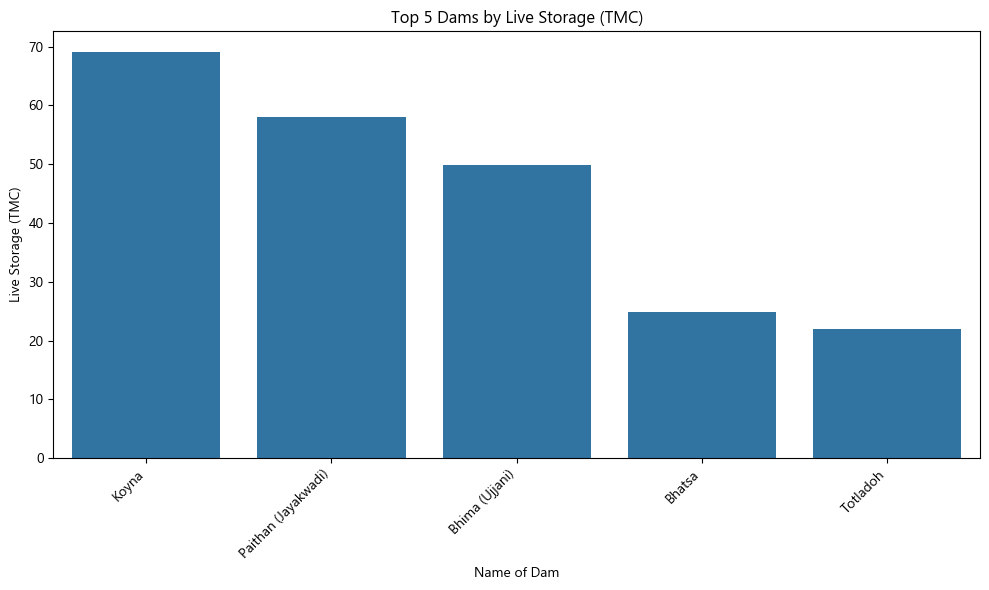

Visualization saved to: plots\seaborn_plot.png


'plots\\seaborn_plot.png'

In [48]:
visualize_data("""import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values(by='live_storage_(tmc)', ascending=False).head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x='name_of_dam', y='live_storage_(tmc)', data=df_sorted)
plt.title('Top 5 Dams by Live Storage (TMC)')
plt.xlabel('Name of Dam')
plt.ylabel('Live Storage (TMC)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()""")

In [53]:
print("\nIntermediate Steps:")
for step in response["intermediate_steps"]:
    print(step[0].tool)
    print(step[0].tool_input)


Intermediate Steps:
VisualizeData
```python
import matplotlib.pyplot as plt
import seaborn as sns

df_sorted = df.sort_values(by='live_storage_(tmc)', ascending=False).head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x='name_of_dam', y='live_storage_(tmc)', data=df_sorted)
plt.title('Top 5 Dams by Live Storage (TMC)')
plt.xlabel('Name of Dam')
plt.ylabel('Live Storage (TMC)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
```


In [56]:
from llama_index.llms.google_genai import GoogleGenAI
from llama_index.core.tools import FunctionTool